In [ ]:
# we need the following libraries, so let's install them
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing libraries
from time import time
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import skimage
import torch
# import SimpleITK as sitk
import skimage, torch, torchvision
# import torchxrayvision as xrv
import torchvision
# import torchxrayvision as xrv
import matplotlib.pyplot as plt
import sys
import warnings
from sklearn.utils import shuffle
import random
import logging
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:


# loadnig the data and removing the useless column 'Unnamed: 0'
whole_data = pd.read_csv('/content/gdrive/MyDrive/radiomics/Chexpert_synced_data_nan_free.csv')
# whole_data = pd.read_csv('Chexpert_synced_data_nan_free.csv')
whole_data.head(5)


,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0,-669.603949,685.781964,1.059520e+10,6.017600,866.092155,1.713989,934.117676,428.763596,10.279660,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,-801.474548,564.486328,1.274714e+10,6.146630,954.811813,1.756523,1020.768616,468.058052,-132.958831,...,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,1.0
2,2,-844.417249,307.704349,9.364581e+09,5.848908,690.788330,1.913630,589.552979,354.572276,-308.642302,...,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,4,-742.036096,673.796082,1.132259e+10,6.076017,1038.149048,1.627926,933.427429,467.972161,-17.909900,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,5,-802.322357,560.980408,1.410547e+10,6.061123,783.288322,2.001557,869.513733,412.838385,-210.721353,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


In [3]:
whole_data.iloc[:,464:]

,feature_463,index,Path,Patient_id,Study_Number,Sex,Age,Race,Ethnicity,Frontal/Lateral,...,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.000408,90979.0,72052 CheXpert-v1.0/train/patient21832/stud...,21832.0,7.0,"72052 Male\nName: Sex, dtype: object",60.0,"72052 White\nName: Race, dtype: object",72052 Non-Hispanic/Non-Latino\nName: Ethnic...,"72052 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000579,104015.0,82339 CheXpert-v1.0/train/patient25007/stud...,25007.0,4.0,"82339 Male\nName: Sex, dtype: object",68.0,"82339 White\nName: Race, dtype: object",82339 Non-Hispanic/Non-Latino\nName: Ethnic...,"82339 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,1.0
2,0.000248,150897.0,120815 CheXpert-v1.0/train/patient35694/stu...,35694.0,10.0,"120815 Female\nName: Sex, dtype: object",77.0,"120815 Other\nName: Race, dtype: object","120815 Hispanic/Latino\nName: Ethnicity, dt...","120815 Frontal\nName: Frontal/Lateral, dtyp...",...,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,0.000395,16394.0,12961 CheXpert-v1.0/train/patient04091/stud...,4091.0,23.0,"12961 Male\nName: Sex, dtype: object",51.0,"12961 White\nName: Race, dtype: object",12961 Non-Hispanic/Non-Latino\nName: Ethnic...,"12961 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.000344,23113.0,18300 CheXpert-v1.0/train/patient05663/stud...,5663.0,3.0,"18300 Male\nName: Sex, dtype: object",58.0,"18300 Unknown\nName: Race, dtype: object","18300 NaN\nName: Ethnicity, dtype: object","18300 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188416,0.000322,214228.0,182285 CheXpert-v1.0/train/patient57730/stu...,57730.0,1.0,"182285 Male\nName: Sex, dtype: object",85.0,"182285 White, non-Hispanic\nName: Race, dty...",182285 Non-Hispanic/Non-Latino\nName: Ethni...,"182285 Frontal\nName: Frontal/Lateral, dtyp...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
188417,0.000492,83627.0,66222 CheXpert-v1.0/train/patient20148/stud...,20148.0,1.0,"66222 Male\nName: Sex, dtype: object",36.0,"66222 White\nName: Race, dtype: object",66222 Non-Hispanic/Non-Latino\nName: Ethnic...,"66222 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,0.0,0.0
188418,0.000460,24975.0,19794 CheXpert-v1.0/train/patient06100/stud...,6100.0,2.0,"19794 Female\nName: Sex, dtype: object",52.0,"19794 White\nName: Race, dtype: object",19794 Non-Hispanic/Non-Latino\nName: Ethnic...,"19794 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
188419,0.000586,112063.0,88781 CheXpert-v1.0/train/patient26840/stud...,26840.0,3.0,"88781 Male\nName: Sex, dtype: object",65.0,"88781 White\nName: Race, dtype: object",88781 Non-Hispanic/Non-Latino\nName: Ethnic...,"88781 Frontal\nName: Frontal/Lateral, dtype...",...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [4]:
2# excludiung Ages with Nans
whole_data = whole_data[~pd.isnull(whole_data['Sex'])]
whole_data.shape

(188421, 489)

In [5]:
new_target = []
for string_target in whole_data['Sex'].values:
  if 'Male' in string_target:
    new_target.append(1)
  elif 'Female' in string_target:
    new_target.append(0)
  else:
    new_target.append(np.nan)
whole_data['New_sex']= new_target

In [6]:
whole_data[['New_sex','Sex']]

,New_sex,Sex
0,1.0,"72052 Male\nName: Sex, dtype: object"
1,1.0,"82339 Male\nName: Sex, dtype: object"
2,0.0,"120815 Female\nName: Sex, dtype: object"
3,1.0,"12961 Male\nName: Sex, dtype: object"
4,1.0,"18300 Male\nName: Sex, dtype: object"
...,...,...
188416,1.0,"182285 Male\nName: Sex, dtype: object"
188417,1.0,"66222 Male\nName: Sex, dtype: object"
188418,0.0,"19794 Female\nName: Sex, dtype: object"
188419,1.0,"88781 Male\nName: Sex, dtype: object"


In [7]:
pd.isnull(whole_data['New_sex']).sum()

1

In [8]:
whole_data = whole_data[~pd.isnull(whole_data['New_sex'])]
whole_data.head()

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,New_sex
0,0,-669.603949,685.781964,1.059520e+10,6.017600,866.092155,1.713989,934.117676,428.763596,10.279660,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1,-801.474548,564.486328,1.274714e+10,6.146630,954.811813,1.756523,1020.768616,468.058052,-132.958831,...,1.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,2,-844.417249,307.704349,9.364581e+09,5.848908,690.788330,1.913630,589.552979,354.572276,-308.642302,...,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,-742.036096,673.796082,1.132259e+10,6.076017,1038.149048,1.627926,933.427429,467.972161,-17.909900,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,5,-802.322357,560.980408,1.410547e+10,6.061123,783.288322,2.001557,869.513733,412.838385,-210.721353,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0


In [9]:
random_seed = 21202
del whole_data['Unnamed: 0']
whole_data.head()
whole_data = whole_data.sample(frac=1.0, random_state=random_seed)

In [10]:
# finding total number of samples:
n_samples = whole_data.shape[0]
print("number of samples are: {}".format(n_samples))

number of samples are: 188420


In [11]:
# names of all targets:
targets_names = list(whole_data.iloc[:,464:])
print(targets_names)

['index', 'Path', 'Patient_id', 'Study_Number', 'Sex', 'Age', 'Race', 'Ethnicity', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'New_sex']


In [12]:
# finding the number of unique subjects:
unique_subjects = pd.unique(whole_data['Patient_id'])
print('The number of unique subjects are: {0}'.format(len(unique_subjects)))

The number of unique subjects are: 64484


In [13]:
# preallocating the frequency of session of the subjects:
# this is written to make sure that we dont use a subject in both training and testing split.
test_split = 0.06       # precent out of total samples
valid_split = 0.1       # precent out of total samples (this is the sumation of both training and validation splits)

n_test = n_samples * test_split
n_whole_train = n_samples - n_test

frequencies = np.ones((unique_subjects.shape[0], 4)) * np.nan
for i, sbj in tqdm(enumerate(unique_subjects)):
  frequencies[i, 0] = sbj
  frequencies[i, 1] = (whole_data['Patient_id'] == sbj).sum()
cumolative_sums_of_samples = np.cumsum(frequencies[:,1])
frequencies[:, 2] = cumolative_sums_of_samples
frequencies[:, 3] = cumolative_sums_of_samples/cumolative_sums_of_samples[~0]

64484it [00:26, 2455.20it/s]


In [14]:
# visualizing the frequency  of subjects and images taken from each
vis_frequencies = pd.DataFrame(frequencies,columns=['subject_ID','n_of_sessions/images','cumolative_sessions','preccent_of_number_of_images'])
vis_frequencies.head(15)

,subject_ID,n_of_sessions/images,cumolative_sessions,preccent_of_number_of_images
0,34504.0,5.0,5.0,0.000027
1,59349.0,2.0,7.0,0.000037
2,38301.0,38.0,45.0,0.000239
3,17270.0,1.0,46.0,0.000244
4,37343.0,3.0,49.0,0.000260
5,35867.0,3.0,52.0,0.000276
6,28124.0,1.0,53.0,0.000281
7,17012.0,13.0,66.0,0.000350
8,38999.0,5.0,71.0,0.000377
9,7951.0,5.0,76.0,0.000403


In [15]:
# separating the testing split without having any mutual_subjects:
testing_subjects_masking = vis_frequencies['preccent_of_number_of_images'] < test_split
testing_subjects = vis_frequencies[testing_subjects_masking]['subject_ID'].values.tolist()
whole_train_subjects = vis_frequencies[~testing_subjects_masking]['subject_ID'].values.tolist()

In [16]:
# excluding irrelevant features
excluding2ds =  np.concatenate( (np.arange(32,41,dtype=int),
                                 np.arange(32,41,dtype=int)+ 116,
                                 np.arange(32,41,dtype=int)+116*2,
                                 np.arange(32,41,dtype=int)+116*3))

whole_data.drop(whole_data.columns[excluding2ds.tolist()],axis = 1,inplace=True)

In [17]:
# separating test_data and whole_trainig_data
Test = whole_data[whole_data['Patient_id'].isin(testing_subjects)]
X_test, y_test = Test.iloc[:,:464-36].values, Test['New_sex'].values

# separating test_data and whole_trainig_data
Train = whole_data[whole_data['Patient_id'].isin(whole_train_subjects)]

# the size of training/testing_split:
print('The size of the testing split is: {}'.format(Test.shape))
print('The size of the whole trainig (train + valid) split is: {}'.format(Train.shape))

The size of the testing split is: (11284, 453)
The size of the whole trainig (train + valid) split is: (177136, 453)


In [18]:
# splitting the validation split:
X_train, X_val, y_train, y_val = train_test_split(Train.iloc[:,:464-36].values,
                                                  Train['New_sex'].values,
                                                  test_size=valid_split,
                                                  random_state=random_seed
                                                  )

In [19]:
from sklearn.decomposition import PCA

inc = 100
# Create a PCA object
pca = PCA(n_components=5)

# Fit the PCA object to the data
pca.fit_transform(X_train[::inc,:])

# Get the principal components
PCs = pca.components_

# Get the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Print the principal components and their variance explained
for i, PC in enumerate(PCs):
    # print('PC {}: {}'.format(i+1, PC))
    print('   Explained variance: {}'.format(explained_variance[i]))

conv = X_train[::inc,:]@pca.components_.T

   Explained variance: 0.5204498610598582
   Explained variance: 0.2370560761411043
   Explained variance: 0.13951519848577595
   Explained variance: 0.10297851763548645
   Explained variance: 2.914046775039999e-07


In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create a LDA model
model = LinearDiscriminantAnalysis()

# Fit the model to the data
# model.fit(X_train[::inc,:], y_train[::inc])

# Predict the labels of new data
predictions = model.fit_transform(X_train[::inc,:], y_train[::inc])

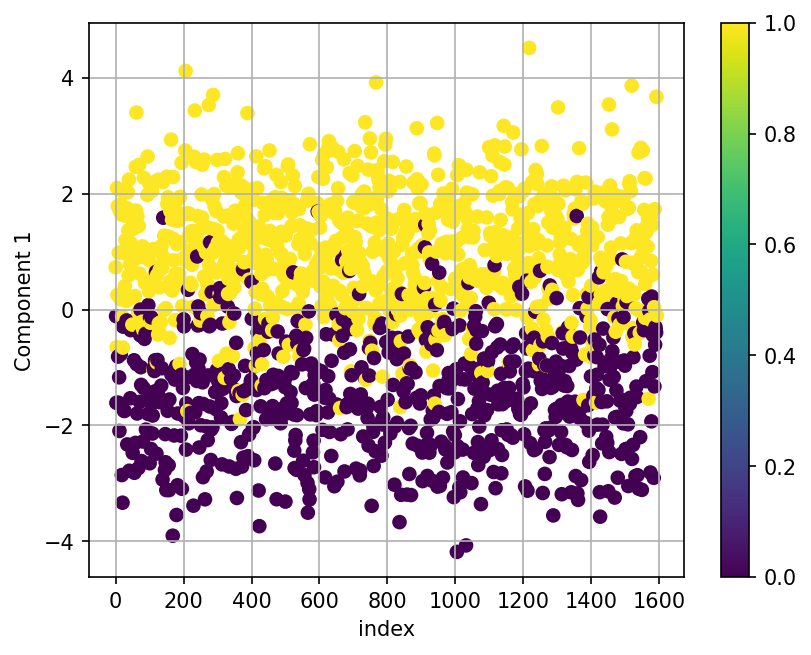

In [21]:
from sklearn.manifold import TSNE
# Load the data
# Create a t-SNE model
tsne = TSNE(n_components=2, perplexity=15,verbose=True,n_iter=2000)
# Fit the model to the data
# tsne_X = tsne.fit_transform(conv)
# Plot the data
plt.figure(dpi=150)
plt.scatter(np.arange(len(predictions)),predictions, c=y_train[::inc])
plt.colorbar()
plt.grid(which='both')
plt.xlabel('index')
plt.ylabel('Component 1')
plt.show()
np.save('/content/gdrive/MyDrive/radiomics/TSNE_chexpert_sex.npy',{'comp':predictions,'c':y_train[::inc]})